# Following shows the steps of doing sensitivity analysis

- before this step, you should set the new time window for each user and then filter the comments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Reddit/rematch_30_Nov/srdd_list_windowed_rematch.csv'
srdd_list = pd.read_csv(file_path, encoding='latin1')

file_path2 = '/content/drive/MyDrive/Reddit/rematch_30_Nov/control_list_windowed_rematch.csv'
control_list = pd.read_csv(file_path2, encoding='latin1')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import timedelta


srdd_list['datetime_utc'] = pd.to_datetime(srdd_list['datetime_utc'], format='%d/%m/%Y %H:%M', errors='coerce')

# new time window
srdd_list['six_months_before'] = srdd_list['datetime_utc'] - pd.DateOffset(months=6)
srdd_list['six_months_after'] = srdd_list['datetime_utc'] + pd.DateOffset(months=6)
srdd_list['three_months_before'] = srdd_list['datetime_utc'] - pd.DateOffset(months=3)
srdd_list['three_months_after'] = srdd_list['datetime_utc'] + pd.DateOffset(months = 3)


In [ ]:
srdd_list

In [ ]:
file_path3 = '/content/drive/MyDrive/Reddit/rematch_30_Nov/df_srdd_comments_windowed_valid_labels_rematch.csv'
srdd_data = pd.read_csv(file_path3, encoding='latin1')

In [ ]:
srdd_data.head(5)

In [ ]:
# filter comments with new time window
# 1 year time window
srdd_data['created_utc'] = pd.to_datetime(srdd_data['created_utc'], format='%Y-%m-%d %H:%M:%S')

def filter_posts_by_time(group, time_ranges):
    author = group.name
    if author in time_ranges:
        start_time = time_ranges[author]['six_months_before']
        end_time = time_ranges[author]['six_months_after']
        return group[(group['created_utc'] >= start_time) & (group['created_utc'] <= end_time)]
    return pd.DataFrame()

time_ranges = srdd_list.set_index('author')[['six_months_before', 'six_months_after']].to_dict('index')

# filter data
grouped = srdd_data.groupby('author')
srdd_data_six_months = grouped.apply(filter_posts_by_time, time_ranges=time_ranges).reset_index(drop=True)

srdd_data_six_months

In [ ]:
srdd_data_six_months.to_csv("/content/drive/MyDrive/Reddit/sensitivity_analysis/df_srdd_comments_six_months.csv",index = False)

In [ ]:
# filter comments with new time window
# 6 month time window

# groupby author
def filter_posts_by_time(group, time_ranges):
    author = group.name
    if author in time_ranges:
        start_time = time_ranges[author]['three_months_before']
        end_time = time_ranges[author]['three_months_after']
        return group[(group['created_utc'] >= start_time) & (group['created_utc'] <= end_time)]
    return pd.DataFrame()

time_ranges = srdd_list.set_index('author')[['three_months_before', 'three_months_after']].to_dict('index')
grouped = srdd_data.groupby('author')
srdd_data_three_months = grouped.apply(filter_posts_by_time, time_ranges=time_ranges).reset_index(drop=True)

srdd_data_three_months

In [ ]:
srdd_data_three_months.to_csv("/content/drive/MyDrive/Reddit/sensitivity_analysis/df_srdd_comments_three_months.csv",index = False)

# **Same process for the control group**

In [ ]:
# First, copy the time windows of users with srdd into the control group with the same mapping.

In [ ]:

columns_to_add = ['six_months_before', 'six_months_after', 'three_months_before', 'three_months_after']
for column in columns_to_add:
    control_list[column] = srdd_list[column]

author_ids = range(1, len(control_list) + 1)
control_list['author_id'] = author_ids
control_list

In [ ]:
file_path4 = '/content/drive/MyDrive/Reddit/rematch_30_Nov/df_control_comments_windowed_valid_labels_rematch.csv'
control_data = pd.read_csv(file_path4, encoding='latin1')
control_data.head(5)

In [ ]:
# 1 year time window
control_data['created_utc'] = pd.to_datetime(control_data['created_utc'], format='%Y-%m-%d %H:%M:%S',errors = "coerce")
def filter_posts_by_time(group, time_ranges):
    author = group.name
    if author in time_ranges:
        start_time = time_ranges[author]['six_months_before']
        end_time = time_ranges[author]['six_months_after']
        return group[(group['created_utc'] >= start_time) & (group['created_utc'] <= end_time)]
    return pd.DataFrame()

time_ranges = control_list.set_index('author_id')[['six_months_before', 'six_months_after']].to_dict('index')
grouped = control_data.groupby('author_id')
control_data_six_months = grouped.apply(filter_posts_by_time, time_ranges=time_ranges).reset_index(drop=True)
control_data_six_months

In [ ]:
control_data_six_months.to_csv("/content/drive/MyDrive/Reddit/sensitivity_analysis/df_control_comments_six_months.csv",index = False)

In [ ]:
# 6 month timw window
def filter_posts_by_time(group, time_ranges):
    author = group.name
    if author in time_ranges:
        start_time = time_ranges[author]['three_months_before']
        end_time = time_ranges[author]['three_months_after']
        return group[(group['created_utc'] >= start_time) & (group['created_utc'] <= end_time)]
    return pd.DataFrame()


time_ranges = control_list.set_index('author_id')[['three_months_before', 'three_months_after']].to_dict('index')
grouped = control_data.groupby('author_id')
control_data_three_months = grouped.apply(filter_posts_by_time, time_ranges=time_ranges).reset_index(drop=True)
control_data_three_months

In [ ]:
control_data_three_months.to_csv("/content/drive/MyDrive/Reddit/sensitivity_analysis/df_control_comments_three_months.csv",index = False)

# **Next, we can do the sensitivity analysis with these new data set:**
* first, we extract labels
* second, we aggregagte labels by the author
* third, we need to examine the sentiment difference (t test)
* fourth, we need to exmaine the emotion difference (t test)
* finally, we need to examine the sentiment instability (whitney u test)

In [ ]:
# extract sentiment and emotion label for each user
import pandas as pd
import ast

# the following function is to get the comment percentage under each sentiment category, same as the process we already did when time window is 2 years
def extract_author_sentiment_emotion(df_control, max_label, emotion_type, author_id):
    df_control[emotion_type] = df_control[emotion_type].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    author_sentiment_counts = df_control.groupby([author_id, max_label]).size().unstack(fill_value=0)
    author_total_counts = author_sentiment_counts.sum(axis=1)
    author_sentiment_percentage = author_sentiment_counts.div(author_total_counts, axis=0) * 100
    control_authors = pd.concat([author_total_counts, author_sentiment_counts,
                                 author_sentiment_percentage.add_suffix('_percentage')], axis=1).reset_index()
    control_authors.rename(columns={0: 'total_count'}, inplace=True)
    emotion_exploded = df_control.explode(emotion_type)

    author_emotion_counts = emotion_exploded.groupby([author_id, emotion_type]).size().unstack(fill_value=0)
    control_authors = control_authors.set_index(author_id)
    for emotion in author_emotion_counts.columns:
        control_authors[f'{emotion}_count'] = author_emotion_counts[emotion].reindex(control_authors.index, fill_value=0)
    control_authors = control_authors.reset_index()

    emotion_types = [col for col in control_authors.columns if col.endswith('_count') and col != 'total_count']
    for emotion_count in emotion_types:
        emotion = emotion_count.replace('_count', '')
        control_authors[f'{emotion}_percentage'] = (control_authors[emotion_count] / control_authors['total_count']) * 100

    return control_authors




In [ ]:
# extract for srdd_data_six_months

srdd_authors_6 = extract_author_sentiment_emotion(df_control = srdd_data_six_months, max_label = "max_label", emotion_type = "emotion_type", author_id = "author")
srdd_authors_6

In [ ]:
control_authors_6 = extract_author_sentiment_emotion(df_control = control_data_six_months, max_label = "max_label", emotion_type = "emotion_type", author_id = "author_id")
control_authors_6

,author_id,total_count,negative,neutral,positive,negative_percentage,neutral_percentage,positive_percentage,anger_count,anticipation_count,...,anticipation_percentage,disgust_percentage,fear_percentage,joy_percentage,love_percentage,optimism_percentage,pessimism_percentage,sadness_percentage,surprise_percentage,trust_percentage
0,1.0,11,2,4,5,18.181818,36.363636,45.454545,0,2,...,18.181818,9.090909,0.000000,72.727273,0.000000,54.545455,0.000000,18.181818,0.000000,0.000000
1,2.0,54,17,15,22,31.481481,27.777778,40.740741,11,16,...,29.629630,18.518519,1.851852,46.296296,11.111111,33.333333,3.703704,7.407407,1.851852,1.851852
2,3.0,131,68,22,41,51.908397,16.793893,31.297710,38,36,...,27.480916,32.061069,5.343511,40.458015,9.923664,41.221374,3.053435,16.793893,4.580153,1.526718
3,4.0,82,15,28,39,18.292683,34.146341,47.560976,7,32,...,39.024390,9.756098,1.219512,54.878049,19.512195,40.243902,1.219512,13.414634,3.658537,0.000000
4,5.0,33,0,0,33,0.000000,0.000000,100.000000,0,0,...,0.000000,0.000000,0.000000,100.000000,81.818182,81.818182,0.000000,0.000000,9.090909,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,1022.0,10,7,1,2,70.000000,10.000000,20.000000,4,5,...,50.000000,40.000000,20.000000,30.000000,10.000000,30.000000,0.000000,10.000000,0.000000,0.000000
955,1023.0,294,118,98,78,40.136054,33.333333,26.530612,62,96,...,32.653061,21.768707,1.360544,41.496599,7.482993,29.251701,6.802721,17.687075,7.482993,0.000000
956,1024.0,2,1,1,0,50.000000,50.000000,0.000000,0,1,...,50.000000,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
957,1025.0,579,291,141,147,50.259067,24.352332,25.388601,237,90,...,15.544041,38.341969,4.145078,45.595855,3.626943,30.051813,1.036269,15.544041,4.145078,1.036269


In [ ]:
import pandas as pd
from scipy import stats

def t_test_between_groups(df_group1, df_group2, emotion_columns):
    # exclude users with comments < 10
    df_group1 = df_group1[df_group1['total_count'] >= 10]
    df_group2 = df_group2[df_group2['total_count'] >= 10]

    result = []

    # t test for comment percentage under each sentiment category
    for column in emotion_columns:
        group1_values = df_group1[column]
        group2_values = df_group2[column]

        mean_group1 = group1_values.mean()
        mean_group2 = group2_values.mean()

        t_stat, p_value = stats.ttest_ind(group1_values, group2_values, nan_policy='omit')

        result.append({
            'emotion_type': column,
            'group1_mean': mean_group1,
            'group2_mean': mean_group2,
            't_statistic': t_stat,
            'p_value': p_value
        })

    result_df = pd.DataFrame(result)
    return result_df


emotion_columns = [
    'negative_percentage', 'neutral_percentage', 'positive_percentage',
    'anger_percentage', 'anticipation_percentage', 'disgust_percentage',
    'fear_percentage', 'joy_percentage', 'love_percentage', 'optimism_percentage',
    'pessimism_percentage', 'sadness_percentage', 'surprise_percentage', 'trust_percentage'
]

result_df = t_test_between_groups(srdd_authors_6, control_authors_6, emotion_columns)

print(result_df)


               emotion_type  group1_mean  group2_mean  t_statistic  \
0       negative_percentage    47.385559    44.385915     3.808183   
1        neutral_percentage    20.067306    24.292897    -8.318664   
2       positive_percentage    32.547136    31.321188     1.583825   
3          anger_percentage    26.371066    28.357249    -2.915123   
4   anticipation_percentage    22.868481    27.011866    -7.342677   
5        disgust_percentage    28.929248    31.291227    -3.310737   
6           fear_percentage     8.401067     4.990337    12.233206   
7            joy_percentage    42.614412    42.414731     0.247768   
8           love_percentage    11.657177     9.625834     4.424407   
9       optimism_percentage    35.172668    32.813485     3.407521   
10     pessimism_percentage     5.660504     3.086276    11.905348   
11       sadness_percentage    22.036493    15.493198    14.574352   
12      surprise_percentage     2.503113     3.096373    -4.618315   
13         trust_per

In [ ]:
# extract for srdd_3_months

srdd_authors_3 = extract_author_sentiment_emotion(df_control = srdd_data_three_months, max_label = "max_label", emotion_type = "emotion_type", author_id = "author")
control_authors_3 = extract_author_sentiment_emotion(df_control = control_data_three_months, max_label = "max_label", emotion_type = "emotion_type", author_id = "author")
control_authors_3


In [ ]:
result_df_2 = t_test_between_groups(srdd_authors_3, control_authors_3, emotion_columns)
print(result_df_2)

               emotion_type  group1_mean  group2_mean  t_statistic  \
0       negative_percentage    47.713691    44.694124     3.168462   
1        neutral_percentage    19.883016    24.018112    -6.673002   
2       positive_percentage    32.403293    31.287764     1.209920   
3          anger_percentage    26.506158    28.312674    -2.189083   
4   anticipation_percentage    22.985446    27.135744    -5.928488   
5        disgust_percentage    29.088656    31.233965    -2.489081   
6           fear_percentage     8.549738     5.102330     9.692587   
7            joy_percentage    42.443364    42.241927     0.208976   
8           love_percentage    11.520875     9.193085     4.423208   
9       optimism_percentage    35.058772    33.020281     2.383630   
10     pessimism_percentage     5.820357     3.187265     9.042998   
11       sadness_percentage    22.193302    15.624241    11.358885   
12      surprise_percentage     2.538953     3.082891    -3.209774   
13         trust_per

# **Next, we need to check the sentiment stability sensitivity**


In [ ]:
def calculate_instability(data, author_id_col, time_col, sentiment_col, min_records=10):
    """
    compute sentiment instability

    param:
        data (pd.DataFrame)。
        author_id_col (str)
        time_col (str)
        sentiment_col (str)
        min_records (int)

    output:
        pd.Series:  sentiment instability for each author, author_id。
    """
    data = data[[author_id_col, time_col, sentiment_col]].copy()


    if data[author_id_col].apply(type).nunique() > 1:
        data[author_id_col] = data[author_id_col].astype(str)

    if data[time_col].dtype != 'datetime64[ns]':
        data[time_col] = pd.to_datetime(data[time_col], errors='coerce')
    data = data.dropna(subset=[time_col])

    data_sorted = data.drop_duplicates().sort_values(by=[author_id_col, time_col])

    author_counts = data_sorted.groupby(author_id_col).size()
    valid_authors = author_counts[author_counts >= min_records].index
    data_sorted = data_sorted[data_sorted[author_id_col].isin(valid_authors)]

    data_sorted['time_diff_minutes'] = (
        data_sorted.groupby(author_id_col)[time_col].diff().dt.total_seconds() / 60
    )
    data_sorted['time_diff_minutes'] = data_sorted['time_diff_minutes'].fillna(0)
    data_sorted['senti_diff'] = data_sorted.groupby(author_id_col)[sentiment_col].diff().abs()

    data_sorted['weighted_senti_diff'] = (
        (data_sorted['senti_diff'] ** 2) / data_sorted['time_diff_minutes']
    )
    data_sorted['weighted_senti_diff'] = data_sorted['weighted_senti_diff'].fillna(0)


    def calculate_weighted_mssd(author_data):
        # median of time diff
        median_time_diff = author_data['time_diff_minutes'].median()
        if len(author_data) > 1:
            weighted_mssd = np.sum(author_data['weighted_senti_diff']) / (len(author_data) - 1)
        else:
            weighted_mssd = 0

        weighted_mssd *= median_time_diff

        return weighted_mssd
    instability_scores = data_sorted.groupby(author_id_col).apply(calculate_weighted_mssd)

    return instability_scores


In [ ]:
import numpy as np
srdd_instability_6 = calculate_instability(
    data=srdd_data_six_months,
    author_id_col='author',
    time_col='created_utc',
    sentiment_col='predicted_class',
    min_records=10
)
srdd_instability_6

In [ ]:
control_data_six_months['predicted_class'] = pd.to_numeric(control_data_six_months['predicted_class'], errors='coerce')

control_instability_6 = calculate_instability(
    data=control_data_six_months,
    author_id_col='author_id',
    time_col='created_utc',
    sentiment_col='predicted_class',
    min_records=10
)
control_instability_6

In [ ]:
import scipy.stats as stats

u_stat, u_p_value = stats.mannwhitneyu(srdd_instability_6, control_instability_6, alternative='two-sided')
print(f"Mann-Whitney U test: stat={u_stat}, p={u_p_value}")

srdd_instability_6_median = srdd_instability_6.median()
srdd_instability_6_mean = srdd_instability_6.mean()
srdd_instability_6_std = srdd_instability_6.std()
control_instability_6_median = control_instability_6.median()
control_instability_6_mean = control_instability_6.mean()
control_instability_6_std = control_instability_6.std()
print(f"SRDD median: {srdd_instability_6_median}, Control median: {control_instability_6_median}")
print(f"SRDD mean: {srdd_instability_6_mean}, COntrol mean: {control_instability_6_mean}")
print(f"SRDD std: {srdd_instability_6_std}, COntrol std: {control_instability_6_std}")

Mann-Whitney U test: stat=361074.0, p=0.0034133300561869665
SRDD median: 28.039556906413047, Control median: 39.486459119432574
SRDD mean: 111.67678875244128, COntrol mean: 109.83065652581534
SRDD std: 549.0132367751387, COntrol std: 225.73498474585824


In [ ]:
srdd_instability_3 = calculate_instability(
    data=srdd_data_three_months,
    author_id_col='author',
    time_col='created_utc',
    sentiment_col='predicted_class',
    min_records=10
)
srdd_instability_3

control_data_three_months['predicted_class'] = pd.to_numeric(control_data_three_months['predicted_class'], errors='coerce')

control_instability_3 = calculate_instability(
    data=control_data_three_months,
    author_id_col='author_id',
    time_col='created_utc',
    sentiment_col='predicted_class',
    min_records=10
)
control_instability_3

In [ ]:
u_stat, u_p_value = stats.mannwhitneyu(srdd_instability_3, control_instability_3, alternative='two-sided')
print(f"Mann-Whitney U test: stat={u_stat}, p={u_p_value}")

srdd_instability_3_median = srdd_instability_3.median()
srdd_instability_3_mean = srdd_instability_3.mean()
srdd_instability_3_std = srdd_instability_3.std()
control_instability_3_median = control_instability_3.median()
control_instability_3_mean = control_instability_3.mean()
control_instability_3_std = control_instability_3.std()
print(f"SRDD median: {srdd_instability_3_median}, Control median: {control_instability_3_median}")
print(f"SRDD mean: {srdd_instability_3_mean}, COntrol mean: {control_instability_3_mean}")
print(f"SRDD std: {srdd_instability_3_std}, COntrol std: {control_instability_3_std}")

Mann-Whitney U test: stat=238139.0, p=0.0023497046325228503
SRDD median: 19.57696014531882, Control median: 31.993406232877252
SRDD mean: 103.16189734979932, COntrol mean: 98.95244552161081
SRDD std: 438.8395941663081, COntrol std: 221.21551796361473


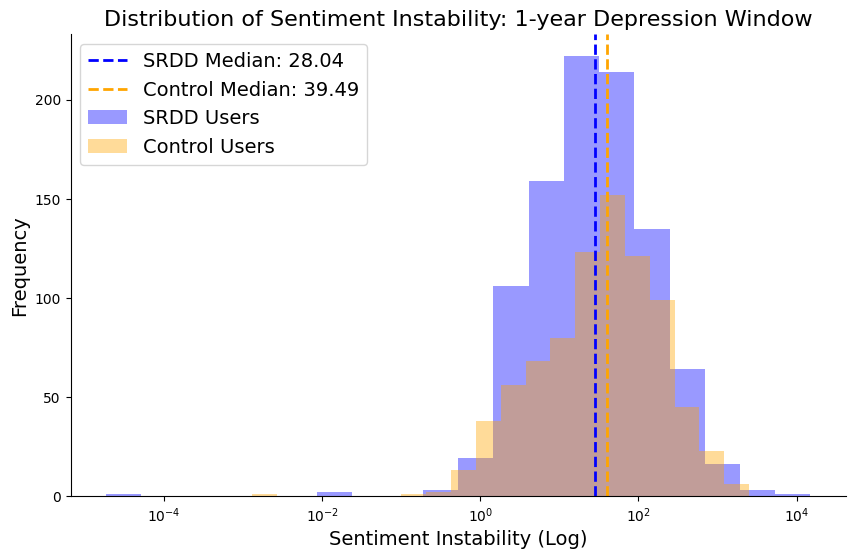

In [ ]:
# Distribution of sentiment instability
# SRDD group

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


srdd_median = np.median(srdd_instability_6)
control_median = np.median(control_instability_6)

plt.figure(figsize=(10, 6))
sns.histplot(srdd_instability_6, kde=False, bins=20, color='blue', edgecolor= None, alpha=0.4, log_scale=True, label='SRDD Users')
sns.histplot(control_instability_6, kde=False, bins=20, color='orange', edgecolor=None, alpha=0.4, log_scale=True, label='Control Users')
plt.axvline(srdd_median, color='blue', linestyle='--', linewidth=2, label=f'SRDD Median: {srdd_median:.2f}')
plt.axvline(control_median, color='orange', linestyle='--', linewidth=2, label=f'Control Median: {control_median:.2f}')
sns.despine()

plt.title('Distribution of Sentiment Instability: 1-year Depression Window', fontsize=16)
plt.xlabel('Sentiment Instability (Log)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=14)

plt.show()


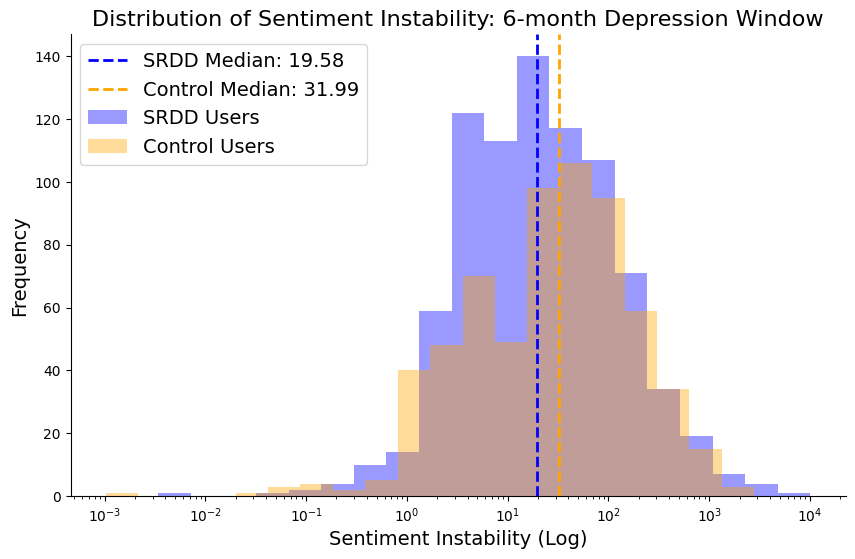

In [ ]:
# Distribution of sentiment instability
# Control group
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

srdd_median = np.median(srdd_instability_3)
control_median = np.median(control_instability_3)

plt.figure(figsize=(10, 6))
sns.histplot(srdd_instability_3, kde=False, bins=20, color='blue', edgecolor= None, alpha=0.4, log_scale=True, label='SRDD Users')
sns.histplot(control_instability_3, kde=False, bins=20, color='orange', edgecolor=None, alpha=0.4, log_scale=True, label='Control Users')
plt.axvline(srdd_median, color='blue', linestyle='--', linewidth=2, label=f'SRDD Median: {srdd_median:.2f}')
plt.axvline(control_median, color='orange', linestyle='--', linewidth=2, label=f'Control Median: {control_median:.2f}')
sns.despine()
plt.title('Distribution of Sentiment Instability: 6-month Depression Window', fontsize=16)
plt.xlabel('Sentiment Instability (Log)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=14)
plt.show()
